# 21기 KNN 정규세션 과제

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.neighbors import KNeighborsRegressor, DistanceMetric, NearestNeighbors

from collections import Counter

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 0. 데이터 불러오기

In [3]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 1. Preprocssing / EDA

In [4]:
df.isnull().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

In [5]:
# Product_Category_2 결측치 채우기 (1)
# 제품 ID 앞 4자리를 기준으로 리스트 생성, 고유값 확인

product_id = []

for i in df.Product_ID.values:
    product_id.append(i[:4])     # 제품 ID를 앞 4자리만 추출하여 product_id 리스트에 추가 - 그룹화 목적

# product_id에서 중복 제거 후 고유값 추출
distinct_product_id = list(set(product_id))     
distinct_product_id

['P002', 'P003', 'P001', 'P000', 'P009']

In [6]:
# Product_Category_2 결측치 채우기 (2)
# 제품 ID 앞 4자리 기준으로 그룹화

P003_index = [i for i, value in enumerate(product_id) if value == 'P003']
P000_index = [i for i, value in enumerate(product_id) if value == 'P000']
P002_index = [i for i, value in enumerate(product_id) if value == 'P002']
P009_index = [i for i, value in enumerate(product_id) if value == 'P009']
P001_index = [i for i, value in enumerate(product_id) if value == 'P001']

print("제품 ID가 P003으로 시작하는 제품 개수:", len(P003_index))
print("제품 ID가 P000으로 시작하는 제품 개수:", len(P000_index))
print("제품 ID가 P002로 시작하는 제품 개수:", len(P002_index))
print("제품 ID가 P009로 시작하는 제품 개수:", len(P009_index))
print("제품 ID가 P001로 시작하는 제품 개수:", len(P001_index))
print('-'*50)
print(len(P003_index)+len(P000_index)+len(P002_index)+len(P009_index)+len(P001_index))

제품 ID가 P003으로 시작하는 제품 개수: 718
제품 ID가 P000으로 시작하는 제품 개수: 1229
제품 ID가 P002로 시작하는 제품 개수: 1282
제품 ID가 P009로 시작하는 제품 개수: 82
제품 ID가 P001로 시작하는 제품 개수: 1687
--------------------------------------------------
4998


In [7]:
# Product_Category_2 결측치 채우기 (3)
# 그룹별 Product_Category_2의 값을 빈도 높은 순으로 확인 

print(Counter(df.Product_Category_2[P003_index]).most_common()[:3])
print(Counter(df.Product_Category_2[P000_index]).most_common()[:3])
print(Counter(df.Product_Category_2[P002_index]).most_common()[:3])
print(Counter(df.Product_Category_2[P009_index]).most_common()[:3])
print(Counter(df.Product_Category_2[P001_index]).most_common()[:3])

[(8.0, 122), (15.0, 60), (14.0, 44)]
[(14.0, 189), (16.0, 130), (2.0, 129)]
[(8.0, 160), (14.0, 102), (2.0, 97)]
[(4.0, 25), (16.0, 11), (8.0, 11)]
[(2.0, 201), (8.0, 187), (14.0, 155)]


In [8]:
# Product_Category_3, User_ID drop
# 결측치 채우기

df_1 = df.drop(['Product_Category_3', 'User_ID'], axis = 1)     # 원본(df) 대신 새로운 변수(df_1) 선언

for i in P003_index:
    if str(df_1.iloc[i, 8]) == 'nan':
        df_1.iloc[i, 8] = 8.0
for i in P000_index:
    if str(df_1.iloc[i, 8]) == 'nan':
        df_1.iloc[i, 8] = 14.0
for i in P002_index:
    if str(df_1.iloc[i, 8]) == 'nan':
        df_1.iloc[i, 8] = 8.0
for i in P009_index:
    if str(df_1.iloc[i, 8]) == 'nan':
        df_1.iloc[i, 8] = 4.0
for i in P001_index:
    if str(df_1.iloc[i, 8]) == 'nan':
        df_1.iloc[i, 8] = 2.0

df_1

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,P00046042,F,0-17,10,A,3,0,5,17.0,2010
1,P00347742,F,0-17,10,A,1,0,7,8.0,4483
2,P00048942,F,0-17,10,A,1,0,1,4.0,7696
3,P00145242,F,0-17,10,A,3,0,2,4.0,16429
4,P00106742,F,0-17,10,A,3,0,3,5.0,5780
...,...,...,...,...,...,...,...,...,...,...
4993,P00147942,M,55+,7,C,1,1,1,16.0,11701
4994,P00358242,M,55+,1,C,1,1,8,8.0,2045
4995,P00173342,M,55+,13,C,3,1,1,6.0,4505
4996,P00336742,M,55+,0,C,2,1,12,8.0,1413


In [9]:
df_1.isnull().sum() 

Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64

In [15]:
# One-Hot-Encoding (1)

categorical_1 = ['Gender', 'Age', 'Occupation', 'City_Category', 
                 'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_Category_2']

encoder_1 = OneHotEncoder().fit(df_1[categorical_1])     # One-Hot-Encoding
encoder_1.get_feature_names_out(categorical_1)     # 각 Feature 이름 확인

array(['Gender_F', 'Gender_M', 'Age_0-17', 'Age_18-25', 'Age_26-35',
       'Age_36-45', 'Age_46-50', 'Age_51-55', 'Age_55+', 'Occupation_0',
       'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4',
       'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8',
       'Occupation_9', 'Occupation_10', 'Occupation_11', 'Occupation_12',
       'Occupation_13', 'Occupation_14', 'Occupation_15', 'Occupation_16',
       'Occupation_17', 'Occupation_18', 'Occupation_19', 'Occupation_20',
       'City_Category_A', 'City_Category_B', 'City_Category_C',
       'Stay_In_Current_City_Years_0', 'Stay_In_Current_City_Years_1',
       'Stay_In_Current_City_Years_2', 'Stay_In_Current_City_Years_3',
       'Stay_In_Current_City_Years_4+', 'Product_Category_1_1',
       'Product_Category_1_2', 'Product_Category_1_3',
       'Product_Category_1_4', 'Product_Category_1_5',
       'Product_Category_1_6', 'Product_Category_1_7',
       'Product_Category_1_8', 'Product_Category_1_9',
  

In [16]:
# One-Hot-Encoding (2) - Product_ID Column

for i in P003_index:     # 먼저 제품 ID 값을 각 제품 ID의 4번째 숫자로 대체 - 그룹화
    df_1.iloc[i, 0] = 3
for i in P000_index:
    df_1.iloc[i, 0] = 0
for i in P002_index:
    df_1.iloc[i, 0] = 2
for i in P009_index:
    df_1.iloc[i, 0] = 9
for i in P001_index:
    df_1.iloc[i, 0] = 1

encoder_2 = OneHotEncoder().fit(df_1[['Product_ID']])     # One-Hot-Encoding
encoder_2.get_feature_names_out(['Product_ID'])   

array(['Product_ID_0', 'Product_ID_1', 'Product_ID_2', 'Product_ID_3',
       'Product_ID_9'], dtype=object)

In [17]:
# 최종 DataFrame 도출

endcoded_data_1 = pd.DataFrame(encoder_1.transform(df_1[categorical_1]).toarray(),
                               index = df_1.index,
                               columns = encoder_1.get_feature_names_out(categorical_1))     # One-Hot-Encoding (1)의 결과를 DataFrame으로!
endcoded_data_2 = pd.DataFrame(encoder_2.transform(df_1[['Product_ID']]).toarray(),
                               index = df_1.index,
                               columns = encoder_2.get_feature_names_out(['Product_ID']))     # One-Hot-Encoding (2)의 결과를 DataFrame으로!

# 위에서 만들어진 DataFrame과 기존 DataFrame concat한 후, One-Hot-Encoding 이전 Categorical Column들은 drop!

df_2 = pd.concat([df_1, endcoded_data_1], sort = False, axis = 1)
df_3 = pd.concat([df_2, endcoded_data_2], sort = False, axis = 1)
df_3 = df_3.drop(['Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
                  'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_Category_2'], axis = 1)

df_3

,Marital_Status,Purchase,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,...,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0,Product_ID_0,Product_ID_1,Product_ID_2,Product_ID_3,Product_ID_9
0,0,2010,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,4483,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,7696,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,16429,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,5780,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,1,11701,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4994,1,2045,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4995,1,4505,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4996,1,1413,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
X = df_3.drop(['Purchase'], axis = 1)     # 피처들
y = df_3.Purchase     # Target

## 2. KNN 구현 & 파라미터 튜닝

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

In [20]:
k_range = range(1, 31)
train_accuracy = []
test_accuracy = []

for k in tqdm_notebook(k_range):
    reg = KNeighborsRegressor(n_neighbors = k)     # default : weights = 'uniform(가중치 없음)', p = 2 (standard Euclidean metric)
    reg.fit(X_train, y_train)
    train_accuracy.append(reg.score(X_train, y_train))     # Train Data에 대한 결정계수
    test_accuracy.append(reg.score(X_test, y_test))     # Test Data에 대한 결정계수

  0%|          | 0/30 [00:00<?, ?it/s]

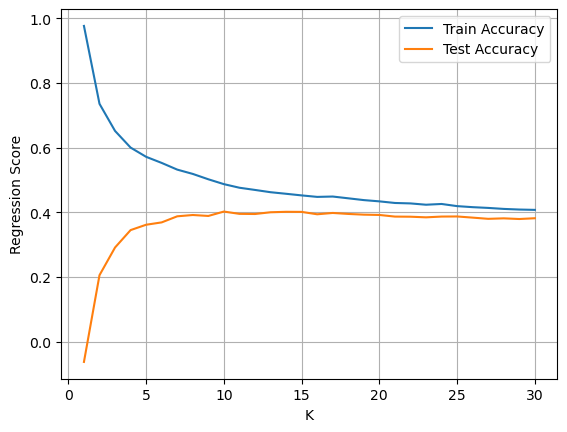

In [21]:
# K 변화에 따른 Accuracy 변화 시각화

plt.plot(k_range, train_accuracy, label = "Train Accuracy")
plt.plot(k_range, test_accuracy, label = "Test Accuracy")
plt.xlabel("K")
plt.ylabel("Regression Score")
plt.grid()
plt.legend()
plt.show()

In [22]:
train_rank_15 = pd.Series(train_accuracy).sort_values(ascending = False).index[:15]
test_rank_15 = pd.Series(test_accuracy).sort_values(ascending = False).index[:15]

print(train_rank_15)
print(test_rank_15)
print()
print(train_rank_15.intersection(test_rank_15))     # train_rank_15와 test_rank_15의 교집합

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')
Int64Index([9, 13, 14, 12, 16, 10, 17, 11, 15, 18, 19, 7, 8, 6, 24], dtype='int64')

Int64Index([6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')


In [23]:
grouped = df.groupby(['Occupation']).mean().sort_values(by = ['Purchase'])
grouped

,User_ID,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
Occupation,,,,,,
19,1.002968e+06,0.150685,5.123288,10.208333,12.277778,8170.465753
6,1.003286e+06,0.489247,6.069892,10.491379,13.756757,8402.354839
0,1.002974e+06,0.445804,5.412587,10.214106,12.953757,8732.351399
10,1.002530e+06,0.073770,4.975410,9.369048,12.128205,8897.926230
20,1.002770e+06,0.477193,5.705263,9.904255,12.194444,8900.733333
11,1.002714e+06,0.463158,5.536842,9.661290,13.617647,8925.147368
13,1.002509e+06,0.446154,5.692308,9.840909,13.909091,8964.907692
4,1.003051e+06,0.260623,5.184136,9.209677,12.545455,9066.113314
16,1.003150e+06,0.483607,5.364754,9.839080,12.800000,9102.409836


In [24]:
Occupation_Low = list(grouped.index[:7])
Occupation_Medium = list(grouped.index[7:14])
Occupation_High = (grouped.index[14:])

print("평균 Purchase가 Low인 Occupation : ", Occupation_Low)
print("평균 Purchase가 Medium인 Occupation : ", Occupation_Medium)
print("평균 Purchase가 High인 Occupation : ", Occupation_High)

평균 Purchase가 Low인 Occupation :  [19, 6, 0, 10, 20, 11, 13]
평균 Purchase가 Medium인 Occupation :  [4, 16, 2, 1, 3, 7, 18]
평균 Purchase가 High인 Occupation :  Int64Index([5, 14, 17, 9, 15, 12, 8], dtype='int64', name='Occupation')


In [25]:
for i in range(len(df_1.Occupation.values)):
    if df_1.Occupation.values[i] in Occupation_Low:
        df_1.iloc[i, 3] = 1
    elif df_1.Occupation.values[i] in Occupation_Medium:
        df_1.iloc[i, 3] = 2
    elif df_1.Occupation.values[i] in Occupation_High:
        df_1.iloc[i, 3] = 3

df_1

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,0,F,0-17,1,A,3,0,5,17.0,2010
1,3,F,0-17,1,A,1,0,7,8.0,4483
2,0,F,0-17,1,A,1,0,1,4.0,7696
3,1,F,0-17,1,A,3,0,2,4.0,16429
4,1,F,0-17,1,A,3,0,3,5.0,5780
...,...,...,...,...,...,...,...,...,...,...
4993,1,M,55+,2,C,1,1,1,16.0,11701
4994,3,M,55+,2,C,1,1,8,8.0,2045
4995,1,M,55+,1,C,3,1,1,6.0,4505
4996,3,M,55+,1,C,2,1,12,8.0,1413


In [27]:
# Occupation별 Purchase의 평균을 기준으로 Occupation column One-Hot-Encoding

encoder_3 = OneHotEncoder().fit(df_1[['Occupation']])     # One-Hot-Encoding
encoder_3.get_feature_names_out(['Occupation'])

array(['Occupation_1', 'Occupation_2', 'Occupation_3'], dtype=object)

In [28]:
# 최종 DataFrame 도출

endcoded_data_3 = pd.DataFrame(encoder_3.transform(df_1[['Occupation']]).toarray(),
                               index = df_1.index,
                               columns = ['Occupation_Low', 'Occupation_Medium', 'Occupation_High'])

# 위에서 만들어진 DataFrame과 기존 DataFrame(df_3)을 concat,
# Occupation 관련 column은 모두 drop

occupation_grouped_df = pd.concat([df_3, endcoded_data_3], sort = False, axis = 1)
occupation_grouped_df.drop(['Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4',
                            'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
                            'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14', 
                            'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18', 'Occupation_19', 'Occupation_20'], 
                           axis = 1, inplace = True)

occupation_grouped_df

,Marital_Status,Purchase,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,...,Product_Category_2_17.0,Product_Category_2_18.0,Product_ID_0,Product_ID_1,Product_ID_2,Product_ID_3,Product_ID_9,Occupation_Low,Occupation_Medium,Occupation_High
0,0,2010,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,4483,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0,7696,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,16429,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,5780,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,1,11701,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4994,1,2045,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4995,1,4505,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4996,1,1413,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


  0%|          | 0/30 [00:00<?, ?it/s]

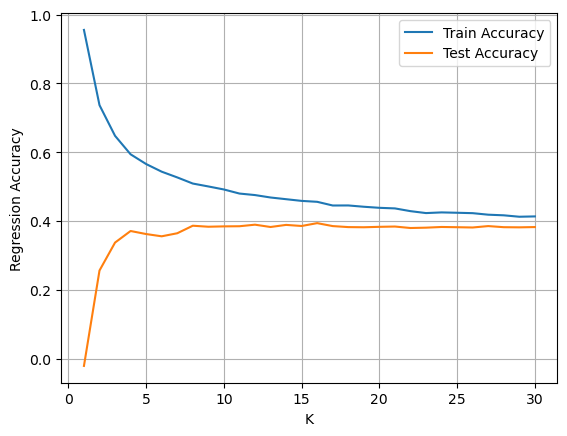

In [29]:
# 설명변수와 Target

X = occupation_grouped_df.drop(['Purchase'], axis = 1)     # 설명변수
y = occupation_grouped_df.Purchase     # Target

# 데이터 분리

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# KNN Regression 구현

k_range = range(1, 31)     # K의 범위는 임의로 1 이상, 30 이하로 제한
train_accuracy = []
test_accuracy = []

for k in tqdm_notebook(k_range):
    reg = KNeighborsRegressor(n_neighbors = k, p = 2)     # default : weights = 'uniform(가중치 없음)'
    reg.fit(X_train, y_train)
    train_accuracy.append(reg.score(X_train, y_train))     # Train Data에 대한 정확도(Accuracy)
    test_accuracy.append(reg.score(X_test, y_test))     # Test Data에 대한 정확도(Accuracy)
    
# K 변화에 따른 Accuracy 변화 시각화

plt.plot(k_range, train_accuracy, label = "Train Accuracy")
plt.plot(k_range, test_accuracy, label = "Test Accuracy")
plt.xlabel("K")
plt.ylabel("Regression Accuracy")
plt.grid()
plt.legend()
plt.show()

In [30]:
# train_accuracy와 test_accuracy를 각각 내림차순 정렬한 후, 상위 9개 값(상위 30%)의 index만 추출

train_rank_9 = pd.Series(train_accuracy).sort_values(ascending = False).index[:9]
test_rank_9 = pd.Series(test_accuracy).sort_values(ascending = False).index[:9]

print(train_rank_9)
print(test_rank_9)
print()
print(train_rank_9.intersection(test_rank_9))     # train_rank_9와 test_rank_9의 교집합

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')
Int64Index([15, 11, 13, 7, 14, 26, 16, 10, 9], dtype='int64')

Int64Index([7], dtype='int64')


In [31]:
cv_scores = []

for k in tqdm_notebook(k_range):
    cv_reg = KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(cv_reg, X_train, y_train)
    cv_scores.append(scores.mean())

  0%|          | 0/30 [00:00<?, ?it/s]

In [32]:
max_acc = np.max(cv_scores)     # Accuracy의 최댓값

best_k = [k_range[i] for i in range(len(cv_scores))     # best_k : Accuracy를 최대로 하는 K를 저장하는 리스트
         if cv_scores[i] == max_acc]

print(max_acc)
print("Besk K Value :", best_k)

0.37012061338874247
Besk K Value : [14]


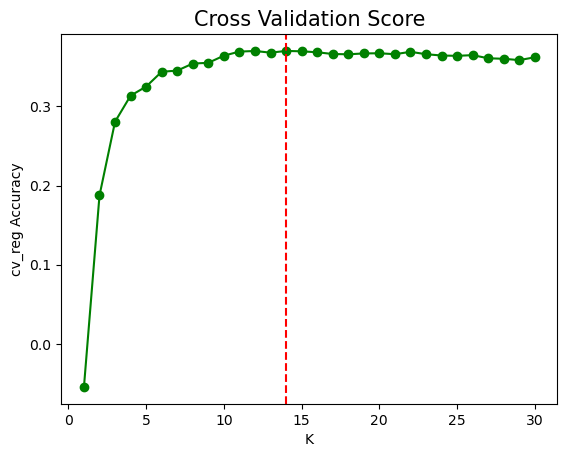

In [33]:
plt.plot(k_range, cv_scores, 'go-')
plt.title("Cross Validation Score", fontsize = 15)
plt.xlabel("K")
plt.ylabel("cv_reg Accuracy")
plt.axvline(best_k[0], color = "r", linestyle = "--")
plt.show()

교차 검증 결과, 상위 30% 안에 드는 K값은 12, 11, 20, 13, 18, 17, 14, 19, 21이고,
그중에서 K = 12일 때 Accuracy가 가장 높다.

## 3. Evaluation